In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import h5py
from salishsea_tools import viz_tools, utilities
import numpy.ma as ma
import datetime
%matplotlib inline

import tools

## Need

1. Visualise 2D thickness and surface oil concentration with scopes and quivers DONE
2. Visualise the concentration with quivers DONE
3. Concentration by depth heat map with sea surface height DONE
4. White cap coverage and Sea surface height where we have oil DONE

### 1. Visualise 2D thickness and surface oil concentration with scopes and quivers

In [2]:
# first, develop tools

# we need the bounds for visualisation as well as the max for both quantities for normalisation
# while we are doing this, we should save the arrays in memory for speed

mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02').tmaskutil.isel(time = 0).values[1:897:,1:397]

def plot_params(array, mask_value = 0):
    """ouput the array bouncding the oil spill area, and return the bounding indices and maximum array value for normalisation
    """
    if len(array.shape) == 3:
        z_indices, y_indices, x_indices = np.where(array != mask_value)
    else: 
        y_indices, x_indices = np.where(array != mask_value)
    if y_indices.shape[0] == 0:
        return False
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()

    if len(array.shape) == 3:
        array = array[...,:,y_min:y_max, x_min:x_max]
    else:
        array = array[y_min:y_max, x_min:x_max]
    maxval = array.max()
    return (array, y_min, y_max, x_min, x_max, maxval)

def surface_conc_params(xarray, mask_values = 0):
    return plot_params(xarray.OilConcentration_3D.isel(grid_z = 39).values)

def thickness_params(xarray, mask_values= 0):
    return plot_params(xarray.Thickness_2D.values)

def make_scope(array):
    if array.sum() != 0:
        scope, ys_min, ys_max, xs_min, xs_max, maxval =  plot_params(array)
        return (scope, ys_min, ys_max, xs_min, xs_max)
    else:
        scope = False

def current_quivers(file, i, ymin, ymax, xmin, xmax):
    """ produce the required arrays for producing current quivers over the oil spill region 
    """
    i = i + 1
    attr = (5 - len(str(i))) * "0" + str(i)
    current_u = file['Results']['velocity U'][f'velocity U_{attr}'][39][xmin:xmax, ymin:ymax]
    current_v = file['Results']['velocity V'][f'velocity V_{attr}'][39][xmin:xmax, ymin:ymax]
    return current_u.T, current_v.T

def ssh(file, i, ymin, ymax, xmin, xmax):
    """ produce the required arrays for sea surface height
    """
    i = i + 1
    attr = (5 - len(str(i))) * "0" + str(i)
    sossheig = file['Results']['water level'][f'water level_{attr}'][xmin:xmax, ymin:ymax]
    return sossheig.T

def wcc(file, i, ymin, ymax, xmin, xmax):
    """ produce the required arrays for whitecap coverage
    """
    i = i + 1
    attr = (5 - len(str(i))) * "0" + str(i)
    whitecap = file['Results']['whitecap coverage'][f'whitecap coverage_{attr}'][xmin:xmax, ymin:ymax]
    return whitecap.T

def produce_mask(yshape, xshape):
    mask = np.ones([yshape,xshape])
    interval = 5
    for i in range(int(yshape/interval)):
        for j in range(int(xshape/interval)):
            mask[i*interval][j*interval] = 0

def wind_quivers(file, i, ymin, ymax, xmin, xmax):
    """ produce the required arrays for producing wind quivers over the oil spill region 
    """
    i = i+1
    attr = (5 - len(str(i))) * "0" + str(i)
    wind_u = file['Results']['wind velocity X'][f'wind velocity X_{attr}'][xmin:xmax, ymin:ymax]
    wind_v = file['Results']['wind velocity Y'][f'wind velocity Y_{attr}'][xmin:xmax, ymin:ymax]
    return wind_u.T, wind_v.T

def when_to_start_rendering(first_time, h5file):
    """produce the index of the time from which to start reading the input files relative
       to the start time from the output Lagrangian.nc file
    """
    first_time = first_time.astype('datetime64[s]').astype(datetime.datetime)
    # go through the timestamps until you get to the one that is concurrent or just ahead of this one
    times =  h5file['Time']
    for i, key in enumerate(times.keys()):
        yr, mo, day, hr, mins, s = np.asarray(times[key]).astype(int)
        timestamp = datetime.datetime(yr, mo, day, hr, mins,s)
        delta = (first_time - timestamp).total_seconds()
        if  delta <= 0:
            # if there is more than an hour of difference, there is a problem
            if delta < (60*60):
                return False
            else:
                return i
        else:
            continue
    return False

In [8]:
"""# construct a 3d array
test_arr = np.zeros([898,398,500])
# get random indices
from random import randint, random
x_indices = np.asarray([randint(0,897) for i in range(100)])
y_indices = np.asarray([randint(0,398) for i in range(100)])
z_indices = np.asarray([randint(0,499) for i in range(100)])
print(x_indices.min(), y_indices.min(), z_indices.min())
print(x_indices.max(), y_indices.max(), z_indices.max())
random_numbers = []
for i in range(100):
    random_number = random()
    test_arr[x_indices[i]][y_indices[i]][z_indices[i]] = random_number
    random_numbers.append(random_number)
random_numbers = np.asarray(random_numbers)
print(random_numbers.max())
plot_params(test_arr)"""



'# construct a 3d array\ntest_arr = np.zeros([898,398,500])\n# get random indices\nfrom random import randint, random\nx_indices = np.asarray([randint(0,897) for i in range(100)])\ny_indices = np.asarray([randint(0,398) for i in range(100)])\nz_indices = np.asarray([randint(0,499) for i in range(100)])\nprint(x_indices.min(), y_indices.min(), z_indices.min())\nprint(x_indices.max(), y_indices.max(), z_indices.max())\nrandom_numbers = []\nfor i in range(100):\n    random_number = random()\n    test_arr[x_indices[i]][y_indices[i]][z_indices[i]] = random_number\n    random_numbers.append(random_number)\nrandom_numbers = np.asarray(random_numbers)\nprint(random_numbers.max())\nplot_params(test_arr)'

In [11]:
def plot_thick_conc(xr_path, currents_path, winds_path, outfile_path, mask = mask):
    # load the netcdf file
    xarray = xr.open_dataset(xr_path)
    # all of the times
    time_values = xarray.time.values
    
    currents = h5py.File(currents_path)
    winds = h5py.File(winds_path)
    first_time = time_values[0]
    
    # make sure you only plot the corrent currents and winds
    currents_start = when_to_start_rendering(first_time, currents)
    winds_start = when_to_start_rendering(first_time, winds)
    
    # check that you have the correct files before you get to the time consuming bits
    assert (currents_start is not False), "Check that you are using correct currents input file"
    assert (winds_start is not False), "Check that you are using the correct winds input file"
    
    # get the plotting parameters for 2D oil thickness
    thickness_param = thickness_params(xarray)
    assert (thickness_param is not False), 'NO OIL THICKNESS FOUND'
    t_array, t_y_min, t_y_max, t_x_min, t_x_max, t_maxval = thickness_param
    
    # get the plotting parameters for suface concentration
    surface_conc_param = surface_conc_params(xarray)
    assert (surface_conc_param is not False), 'NO SURFACE OIL CONCENTRATION FOUND'
    c_array, c_y_min, c_y_max, c_x_min, c_x_max, c_maxval = surface_conc_param
    
    # land masks
    t_mask = mask[t_y_min: t_y_max, t_x_min: t_x_max] # mask for oil thickness
    c_mask = mask[c_y_min: c_y_max, c_x_min: c_x_max] # mask for oil surface concentration   
    
    t_q_mask = produce_mask(t_y_max-t_y_min, t_x_max-t_x_min) # mask out every fifth quiver along each axis for thickness
    c_q_mask = produce_mask(c_y_max-c_y_min, c_x_max-c_x_min) # mask out every fifth quiver along each axis for concentration
    
    def update_frame(t, 
                     t_array = t_array, t_y_min = t_y_min, t_y_max = t_y_max, t_x_min = t_x_min, t_x_max = t_x_max, t_maxval = t_maxval,
                     c_array = c_array, c_y_min = c_y_min, c_y_max = c_y_max, c_x_min = c_x_min, c_x_max = c_x_max, c_maxval = c_maxval,
                     times = time_values, t_mask = t_mask, c_mask = c_mask, t_q_mask = t_q_mask, c_q_mask = c_q_mask,
                     current = currents, wind = winds, currents_start = currents_start, winds_start = winds_start
                    ):
        # set up the subplot layout
        grid = plt.GridSpec(2,3)
        # !----------------------------------------------------------------------------------------------------------------------------
        # plot the surface oil thickness
        ax = plt.subplot(grid[0:,0])
        thickness = t_array[t]
        # get whatever should be in the scope
        scope_result = make_scope(thickness)
        if scope_result is (False or None):
            scope = False
        else:
            scope, ys_min, ys_max, xs_min, xs_max = scope_result
        
        # for the horizontal markers on the colorbar
        thickmin, thickmax = thickness.min(), thickness.max()
        # mask out the zeros
        condlist = [thickness == 0, thickness != 0]
        choicelist = [np.nan, thickness]
        thickness = np.select(condlist, choicelist)
        
        # plot full region normalised to log scale
        plt.pcolormesh(thickness, 
                       animated = True,
                       norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                       vmin = 0.0001,
                       vmax = t_maxval,
                       cmap = 'inferno')
        
        # plot the scope boundaries
        if scope is not False:
            plt.hlines(ys_max, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.hlines(ys_min, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.vlines(xs_max, ymin = ys_min, ymax = ys_max, colors = 'Green')
            plt.vlines(xs_min, ymin = ys_min, ymax = ys_max, colors = 'Green')
        
        # plot colorbar normalised to log scale, with current min and max thicknesses
        cbar = plt.colorbar(plt.pcolormesh(np.meshgrid(np.array([0.0001, t_maxval])),
                                           norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                                           cmap = 'inferno'))
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('Oil thickness (microns)', rotation=270)
        cbar.ax.hlines(thickmax, xmin =  0, xmax = 150, colors = 'Red')
        cbar.ax.hlines(thickmin, xmin =  0, xmax = 150, colors = 'Blue')
        # plot the land mask and coastline
        plt.contourf(t_mask, levels = [-0.1, 0.1], colors = 'Burlywood')
        plt.contour(t_mask, levels = [-0.1, 0.1], colors = 'k')        
        # thickness limits readouts
        plt.title(f'max thickness {thickmax}\nmin thickness {thickmin}')
        # plot current quivers
        U, V = current_quivers(current, t + currents_start, t_y_min, t_y_max, t_x_min, t_x_max)
        # mask out everything but every nth quiver
        U_ma, V_ma = ma.array(U, mask = t_q_mask), ma.array(V, mask = t_q_mask)
        currentq = plt.quiver(U_ma, V_ma, scale = 20, width = 0.003)
        plt.quiverkey(currentq, 1.13, 1.92, 1, label = 'Current (1 m/s)', transform=ax.transAxes)
        u, v = wind_quivers(wind, t + winds_start, t_y_min, t_y_max, t_x_min, t_x_max)
        u,v = np.average(u), np.average(v)
        windq = plt.quiver(10, t_y_max - t_y_min - 10, u, v, scale = 20, color = 'Red')
        plt.quiverkey(windq, 1.13,1.8, 5, label = 'Wind (5 m/s)', transform=ax.transAxes)
        
        viz_tools.set_aspect(ax)
        
        # !-----------------------------------------------------------------------------------------------------------------------------
        # plot the 2D thickness scope
        ax = plt.subplot(grid[0, 2])
        if scope is False:
            plt.cla()
            plt.xticks([])
            plt.yticks([])
        else:
            # mask out the scope contants, plot land mask and coastline
            condlist = [scope == 0, scope != 0]
            choicelist = [np.nan, scope]
            plt.pcolormesh(np.select(condlist, choicelist),
                           animated = True,
                           norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                           vmin = 0.0001,
                           vmax = t_maxval,
                           cmap = 'inferno')
            scope_mask = t_mask[ys_min:ys_max, xs_min:xs_max]
            plt.contourf(scope_mask,
                         levels = [-0.1, 0.1],
                         colors = 'Burlywood')
            plt.contour(scope_mask,
                        levels = [-0.1, 0.1],
                        colors = 'k')
            # plot the quivers
            U, V = U_ma[ys_min:ys_max, xs_min:xs_max],V_ma[ys_min:ys_max, xs_min:xs_max]
            plt.quiver(U,V , scale = 20 ,width = 0.003, headwidth = 3)
            
            # remove axis ticks
            plt.xticks([])
            plt.yticks([])
            plt.title('Oil Thickness Scope')
        # !----------------------------------------------------------------------------------------------------------------------------
        ax = plt.subplot(grid[0:,1])
        concentration = c_array[t]
        # get whatever should be in the scope
        scope_result = make_scope(concentration)
        if scope_result is (False or None):
            scope = False
        else:
            scope, ys_min, ys_max, xs_min, xs_max = scope_result  
        
        # for the horizontal markers on the colorbar
        concmin, concmax = concentration.min(), concentration.max()
        
        # mask out the zeros
        condlist = [concentration == 0, concentration != 0]
        choicelist = [np.nan, concentration]
        concentration = np.select(condlist, choicelist)

        # plot full region normalised to log scale
        plt.pcolormesh(concentration, 
                       animated = True,
                       norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                       vmin = 0.0001,
                       vmax = c_maxval,
                       cmap = 'inferno')
        # plot the scope boundaries
        if scope is not False:
            plt.hlines(ys_max, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.hlines(ys_min, xmin = xs_min, xmax = xs_max, colors = 'Green')
            plt.vlines(xs_max, ymin = ys_min, ymax = ys_max, colors = 'Green')
            plt.vlines(xs_min, ymin = ys_min, ymax = ys_max, colors = 'Green')
            
        # plot colorbar normalised to log scale, with current min and max concentrations
        cbar = plt.colorbar(plt.pcolormesh(np.meshgrid(np.array([0.0001, c_maxval])),
                                           norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                                           cmap = 'inferno'))
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('Oil concentration (ppm)', rotation=270)
        cbar.ax.hlines(concmax, xmin =  0, xmax = 300, colors = 'Red')
        cbar.ax.hlines(concmin, xmin =  0, xmax = 300, colors = 'Blue')
        # plot the land mask and coastline
        plt.contourf(c_mask, levels = [-0.1, 0.1], colors = 'Burlywood')
        plt.contour(c_mask, levels = [-0.1, 0.1], colors = 'k')        
        # thickness limits readouts
        plt.title(f'max concentration {concmax}\nmin concentration {concmin}')
        # plot current quivers
        U, V = current_quivers(current, t + currents_start, c_y_min, c_y_max, c_x_min, c_x_max)
        # mask out everything but every nth quiver
        U_ma, V_ma = ma.array(U, mask = c_q_mask), ma.array(V, mask = c_q_mask)
        currentq = plt.quiver(U_ma, V_ma, scale = 20, width = 0.003)
        plt.quiverkey(currentq, 1.13, 1.92, 1, label = 'Current (1 m/s)', transform=ax.transAxes)
        
        u, v = wind_quivers(wind, t + winds_start, c_y_min, c_y_max, c_x_min, c_x_max)
        u,v = np.average(u), np.average(v)
        windq = plt.quiver(10, c_y_max - c_y_min - 10, u, v, scale = 20, color = 'Red')
        plt.quiverkey(windq, 1.13,1.8, 5, label = 'Wind (5 m/s)', transform=ax.transAxes)
        
        viz_tools.set_aspect(ax)        
        
        # !------------------------------------------------------------------------------------------------------------------------------
        ax = plt.subplot(grid[1,2])
        if scope is False:
            plt.cla()
            plt.xticks([])
            plt.yticks([])
        else:
            # mask out the scope contants, plot land mask and coastline
            condlist = [scope == 0, scope != 0]
            choicelist = [np.nan, scope]
            plt.pcolormesh(np.select(condlist, choicelist),
                           animated = True,
                           norm=colors.LogNorm(vmin=0.0001, vmax=c_maxval),
                           vmin = 0.0001,
                           vmax = c_maxval,
                           cmap = 'inferno')
            scope_mask = c_mask[ys_min:ys_max, xs_min:xs_max]
            plt.contourf(scope_mask,
                         levels = [-0.1, 0.1],
                         colors = 'Burlywood')
            plt.contour(scope_mask,
                        levels = [-0.1, 0.1],
                        colors = 'k')
            # plot the quivers
            U, V = U_ma[ys_min:ys_max, xs_min:xs_max],V_ma[ys_min:ys_max, xs_min:xs_max]
            plt.quiver(U,V , scale = 20 ,width = 0.003, headwidth = 3)
            
            # remove axis ticks
            plt.xticks([])
            plt.yticks([])
            plt.title('Oil Concentration Scope')
        #plt.tight_layout()
        plt.suptitle(times[t])
        # !----------------------------------------------------------------------------------------------------------------------------
    fig = plt.figure(figsize = (16,9))
    ani = animation.FuncAnimation(plt.gcf(), update_frame, range(time_values.shape[0]))
    ani.save(outfile_path, writer = animation.FFMpegWriter(), dpi = 100)

In [12]:
plot_thick_conc('/home/abhudia/viz_test/vvl/Lagrangian_SOGa_01dec17_MF0_1000m3_7days_unrotated_smalldt_vvl.nc',
                '/home/abhudia/viz_test/forcing/currents.hdf5',
                '/home/abhudia/viz_test/forcing/winds.hdf5',
                '/home/abhudia/current_u/test.mp4')

AssertionError: Check that you are using correct currents input file

In [13]:
xr.open_dataset('/home/abhudia/viz_test/vvl/Lagrangian_SOGa_01dec17_MF0_1000m3_7days_unrotated_smalldt_vvl.nc')

<xarray.Dataset>
Dimensions:              (grid_x: 396, grid_y: 896, grid_z: 40, time: 484)
Coordinates:
  * time                 (time) datetime64[ns] 2017-12-01T05:30:00 ... 2017-12-07T22:30:00
  * grid_y               (grid_y) int16 0 1 2 3 4 5 ... 890 891 892 893 894 895
  * grid_x               (grid_x) int16 0 1 2 3 4 5 ... 390 391 392 393 394 395
  * grid_z               (grid_z) int16 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
Data variables:
    OilConcentration_2D  (time, grid_y, grid_x) float64 ...
    Thickness_2D         (time, grid_y, grid_x) float64 ...
    Dissolution_3D       (time, grid_z, grid_y, grid_x) float64 ...
    OilConcentration_3D  (time, grid_z, grid_y, grid_x) float64 ...
    Beaching_Time        (grid_y, grid_x) datetime64[ns] ...
    Oil_Arrival_Time     (grid_y, grid_x) datetime64[ns] ...
Attributes:
    nco_openmp_thread_number:   1
    history:                    Mon Apr  1 19:28:48 2019: ncks -4 -L4 -A /loc...
    NCO:                        4.6.6
    

In [11]:
# find the wcc and ssh at the oil spill locations
def plot_thickness_with_ssh(xr_path, sea_level, ww3, currents_path, winds, output, mask = mask):
    # load the netcdf file
    xarray = xr.open_dataset(xr_path)
    # get the plotting parameters for 2D oil thickness
    thickness_param = thickness_params(xarray)
    assert (thickness_param is not False), 'NO OIL THICKNESS FOUND'
    t_array, t_y_min, t_y_max, t_x_min, t_x_max, t_maxval = thickness_param
    
    time_values = xarray.time.values
    # read only the times from the input files that correspond to the timestamp in the netcdf file. 
    first_time = time+valjues[0]
    # land mask
    t_mask = mask[t_y_min: t_y_max, t_x_min: t_x_max] # mask for oil thickness
    
    currents = h5py.File(currents_path)
    winds = h5py.File(winds)
    t_q_mask = produce_mask(t_y_max-t_y_min, t_x_max-t_x_min)
    sea_level = h5py.File(sea_level)
    ww3 = h5py.File(ww3)
    avg_norm, avg_abnorm = [],[]
    savg_norm, savg_abnorm = [],[]
    time_norm, time_abnorm = [],[]
    tref_sea_level = when_to_start_rendering(first_time, sea_level)
    t_ref_ww3 = when_to_start_rendering(first_time, ww3)
    for t in range(time_values.shape[0]):
        thickness = t_array[t]

        sossheig = ssh(sea_level, tref_sea_level+t, t_y_min, t_y_max, t_x_min, t_x_max)
        condlist = [t_mask == 0, t_mask == 1]
        choicelist = [np.nan, sossheig]
        sossheig = np.select(condlist, choicelist)
        try:
            whitecap = wcc(ww3, 2*(tref_ww3+t), t_y_min, t_y_max, t_x_min, t_x_max)
            condlist = [t_mask == 0, t_mask == 1]
            choicelist = [np.nan, whitecap]
            whitecap = np.select(condlist, choicelist)
        except KeyError:
            break
        
        if thickness.sum() == 0:
            # then we just get an average across the domain of the oil spill
            avg_sossheig = np.nanmean(sossheig)
            avg_whitecap = np.nanmean(whitecap)
            avg_abnorm.append(avg_soss)
            savg_abnorm.append(avg_wcc)
            time_abnorm.append(time_values[t])
        else:
            indices = np.where(thickness != 0)
            avg_sossheig = np.nanmean(sossheig[indices])
            avg_whitecap = np.nanmean(whitecap[indices])
            avg_norm.append(avg_soss)
            savg_norm.append(avg_wcc)
            time_norm.append(time_values[t])


    max_ylim = max([max(avg_norm), max(avg_abnorm)])
    min_ylim = min([min(avg_norm), min(avg_abnorm)])
    smax_ylim = max([max(savg_norm), max(savg_abnorm)])
    smin_ylim = min([min(savg_norm), min(savg_abnorm)])
    
    def update_frame(t, 
                     t_array = t_array, t_y_min = t_y_min, t_y_max = t_y_max, t_x_min = t_x_min, t_x_max = t_x_max, t_maxval = t_maxval,
                     times = time_values, t_mask = t_mask, t_q_mask = t_q_mask,
                     avg_norm = avg_norm, min_norm = min_norm, max_norm = max_norm,
                     avg_abnorm = avg_abnorm, min_abnorm = min_abnorm, max_abnorm = max_abnorm, 
                     max_ylim = max_ylim, min_ylim = min_ylim,
                     smax_ylim = smax_ylim, smin_ylim = smin_ylim,
                     current = currents, wind = winds, tim_norm = time_norm, time_abnorm = time_abnorm
                    ):
        # !----------------------------------------------------------------------------------------------------------------------------
        grid = plt.GridSpec(2,3)
        ax = plt.subplot(grid[0:,0])
        # plot the surface oil thickness
        thickness = t_array[t]
        # for the horizontal markers on the colorbar
        thickmin, thickmax = thickness.min(), thickness.max()
        # mask out the zeros
        condlist = [thickness == 0, thickness != 0]
        choicelist = [np.nan, thickness]
        thickness = np.select(condlist, choicelist)
        
        # plot full region normalised to log scale
        plt.pcolormesh(thickness, 
                       animated = True,
                       norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                       vmin = 0.0001,
                       vmax = t_maxval,
                       cmap = 'inferno')
            
        # plot colorbar normalised to log scale, with current min and max thicknesses
        cbar = plt.colorbar(plt.pcolormesh(np.meshgrid(np.array([0.0001, t_maxval])),
                                           norm=colors.LogNorm(vmin=0.0001, vmax=t_maxval),
                                           cmap = 'inferno'))
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('Oil thickness (microns)', rotation=270)
        cbar.ax.hlines(thickmax, xmin =  0, xmax = 150, colors = 'Red')
        cbar.ax.hlines(thickmin, xmin =  0, xmax = 150, colors = 'Blue')
        # plot the land mask and coastline
        plt.contourf(t_mask, levels = [-0.1, 0.1], colors = 'Burlywood')
        plt.contour(t_mask, levels = [-0.1, 0.1], colors = 'k')        
        # thickness limits readouts
        plt.title(f'max thickness {thickmax}\nmin thickness {thickmin}')
        # plot current quivers
        U, V = current_quivers(current, t, t_y_min, t_y_max, t_x_min, t_x_max)
        # mask out everything but every nth quiver
        U_ma, V_ma = ma.array(U, mask = t_q_mask), ma.array(V, mask = t_q_mask)
        currentq = plt.quiver(U_ma, V_ma, scale = 20, width = 0.003)
        plt.quiverkey(currentq, 1.13, 1.92, 1, label = 'Current (1 m/s)', transform=ax.transAxes)
        u, v = wind_quivers(wind, t, t_y_min, t_y_max, t_x_min, t_x_max)
        u,v = np.average(u), np.average(v)
        windq = plt.quiver(10, t_y_max - t_y_min - 10, u, v, scale = 20, color = 'Red')
        plt.quiverkey(windq, 1.13,1.8, 5, label = 'Wind (5 m/s)', transform=ax.transAxes)
        
        viz_tools.set_aspect(ax)
        
        # !-----------------------------------------------------------------------------------------------------------------------------
        # plot the ssh
        ax1 = plt.subplot(grid[0,1:])
        plt.plot(time_norm, avg_norm, 'b-', label = 'average sossheig w/ oil')
        plt.plot(time_abnorm, avg_abnorm, 'r-', label = 'average sossheig w/o oil')
        ax1.set_xlim(xmin = times[0], xmax = times[-1])
        ax1.axvline(x = times[t], ymin = min_ylim,ymax = max_ylim)
        plt.legend()
        plt.title('Sea surface height (m)')

        # !----------------------------------------------------------------------------------------------------------------------------
        ax2 = plt.subplot(grid[1, 1:])
        plt.plot(time_norm, savg_norm, 'b-', label = 'average whitecap coverage w/ oil')
        plt.plot(time_abnorm, savg_abnorm, 'r-', label = 'average whitecap coverage w/o oil')
        ax2.set_xlim(xmin = times[0], xmax = times[-1])
        ax2.axvline(x = times[t], ymin = smin_ylim,ymax = smax_ylim)
        plt.legend()
        plt.title('Whitecap Coverage (m)')
        
        print(t)
        # !----------------------------------------------------------------------------------------------------------------------------
    fig = plt.figure(figsize = (16,9))
    ani = animation.FuncAnimation(plt.gcf(), update_frame, range(time_values.shape[0]))
    ani.save(output, writer = animation.FFMpegWriter(), dpi = 100)

In [ ]:
plot_thickness_with_ssh('/home/abhudia/viz_test/oil.nc',
                        '/home/abhudia/viz_test/t.hdf5',
                        '/home/abhudia/viz_test/ww3.hdf5',
                        '/home/abhudia/viz_test/curr.hdf5',
                        '/home/abhudia/viz_test/winds.hdf5',
                        '/home/abhudia/viz_test/thick_ssh.mp4')

In [26]:
import datetime

In [29]:
xr.open_dataset('/home/abhudia/viz_test/oil.nc').time[0].values.astype('datetime64[s]').astype(datetime.datetime)

datetime.datetime(2017, 12, 1, 5, 30)

In [21]:
np.sum(np.sum(oil.OilConcentration_3D.isel(time = 0).values, axis = 1), axis = 1).shape

(40,)

In [3]:
def conc_heatmap(oilpath):
    oil = xr.open_dataset(oilpath)
    ## concentration by depth heat map
    # go through entire record and create array
    # first, find the number of time stamps
    time_values = oil.time.values
    number_steps = time_values.shape[0]
    conc_heatmap = np.zeros([40,number_steps])
    bar = utilities.statusbar('Loading...')
    for t in bar(range(number_steps)):
        # sum along x and y axes to get concentration at each depth
        conc_vals = np.sum(np.sum(oil.OilConcentration_3D.isel(time = t).values, axis = 1), axis = 1)
        # add this to the heatmap array
        conc_heatmap[:,t] = conc_vals
    # cut out the useless bits
    conc_heatmap = conc_heatmap[~(conc_heatmap==0).all(1)]
    # get the limits
    condlist = [conc_heatmap == 0, conc_heatmap != 0]
    choicelist = [np.nan, conc_heatmap]
    conc_heatmap = np.select(condlist, choicelist)
    vmax, vmin = np.nanmax(conc_heatmap), np.nanmin(conc_heatmap)
    # get the corresponding depth values
    depths = conc_heatmap.shape[0]
    depth = np.flip(np.array([0.      ,   1.000001,   2.000006,   3.000019,   4.000047,   5.000104,
                      6.000217,   7.000441,   8.000879,   9.001736,  10.003407,  11.006662,
                      12.013008,  13.025366,  14.049429,  15.096255,  16.187304,  17.364035,
                      18.705973,  20.363474,  22.613064,  25.937412,  31.101034,  39.11886 ,
                      50.963238,  67.05207 ,  86.96747 , 109.73707 , 134.34593 , 160.02956 ,
                      186.30528 , 212.89656 , 239.65305 , 266.4952  , 293.3816  , 320.29077 ,
                      347.2116  , 374.1385  , 401.06845 , 428.      ])[1:depths+1])
    # now make the plot
    fig = plt.figure(figsize = (15,15))
    #  normaise on log10 scale
    plt.pcolormesh(conc_heatmap,
                   animated = True,
                   norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                   vmin = vmin,
                   vmax = vmax,
                   cmap = 'inferno')
    plt.yticks(range(depths), depth)
    plt.xticks(np.arange(0, number_steps, 24), time_values[::24], rotation='vertical')
    # plot colorbar normalised to log scale, with current min and max thicknesses
    plt.colorbar()
    plt.title('Oil Concentration (ppm)')
    plt.ylabel('Depth (m)')

In [4]:
conc_heatmap('/home/abhudia/viz_test/vvl/Lagrangian_SOGa_01dec17_MF0_1000m3_7days_unrotated_smalldt_vvl.nc')

Loading... 100% (484 of 484) |##################################|Time:  0:02:01


ValueError: zero-size array to reduction operation fmax which has no identity

In [32]:
h5file['Time'].keys()

KeysView(<HDF5 group "/Time" (168 members)>)

In [40]:
first_time = xr.open_dataset('/home/abhudia/viz_test/oil.nc').time.isel(time = 0).values
h5file = h5py.File('/home/abhudia/viz_test/winds.hdf5')
when_to_start_rendering(first_time, h5file)

6

In [72]:
import tables
f = tables.open_file('/home/abhudia/viz_test/Lagrangian_SOGa_01dec17_MF0_1000m3_7days_hi_test.hdf5')
for i in f.walk_groups():
    print(i)

/ (RootGroup) ''
/Grid (Group) ''
/Results (Group) ''
/Time (Group) ''
/Results/Group_1 (Group) ''
/Results/Number (Group) ''
/Results/OilSpill (Group) ''
/Results/Percentage Contaminated (Group) ''
/Results/OilSpill/Beached (Group) ''
/Results/OilSpill/Data_2D (Group) ''
/Results/OilSpill/Data_3D (Group) ''
/Results/OilSpill/Freazed (Group) ''
/Results/OilSpill/Latitude (Group) ''
/Results/OilSpill/Latitude average (Group) ''
/Results/OilSpill/Longitude (Group) ''
/Results/OilSpill/Longitude average (Group) ''
/Results/OilSpill/Model ID (Group) ''
/Results/OilSpill/Origin ID (Group) ''
/Results/OilSpill/Particle State (Group) ''
/Results/OilSpill/Surface State (Group) ''
/Results/OilSpill/Thickness (Group) ''
/Results/OilSpill/Volume (Group) ''
/Results/OilSpill/X Pos (Group) ''
/Results/OilSpill/Y Pos (Group) ''
/Results/OilSpill/Z Pos (Group) ''
/Results/OilSpill/oil (Group) ''
/Results/OilSpill/Data_3D/Dissolution_3D (Group) ''
/Results/OilSpill/Data_3D/OilConcentration_3D (Group) 

In [73]:
f = h5py.File('/home/abhudia/viz_test/Lagrangian_SOGa_01dec17_MF0_1000m3_7days_hi_test.hdf5')

In [78]:
a = np.asarray(f['Grid']['VerticalZ']['Vertical_00001'])

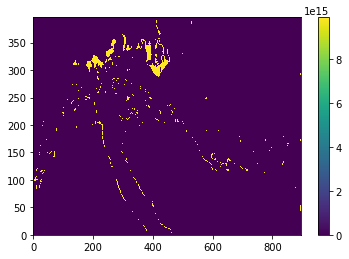

In [84]:
plt.pcolormesh(a[39]-a[30])
plt.colorbar()

In [6]:
from random import randint

In [13]:
a = np.reshape(np.asarray([randint(0,1) for i in range(100)]),[10,10])

In [20]:
a[2:3, 2:3]

array([[1]])

In [25]:
a[2:4, 1:3]= np.array([[2,2],[2,2]])

In [26]:
a

array([[1, 0, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 2, 2, 1, 1, 1, 0, 1, 0, 1],
       [0, 2, 2, 0, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 1, 0, 0, 0]])